In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import feather
import datetime

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook
import os
import gc
import lightgbm as lgb

In [2]:
#Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object and col !="timestamp":  # Exclude strings        
            # Print current column type
            #print("******************************")
            #print("Column: ",col)
            #print("dtype before: ",df[col].dtype)      
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            #print("dtype after: ",df[col].dtype)
    # Print final result
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("MEMORY USAGE AFTER COMPLETION: Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [3]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Data

In [4]:
directory = '../input/ashrae-prepare-by-feather'
os.listdir("../input/ashrae-leak-data")

['__notebook__.ipynb',
 'submission_leak.csv',
 '__results__.html',
 '__output__.json',
 '__results___files',
 'custom.css',
 'leak.csv']

In [5]:
%%time
df_train = feather.read_dataframe(directory+'/train.feather')
weather_train = feather.read_dataframe(directory+'/weather_train.feather')
building_metadata = feather.read_dataframe(directory+'/building_metadata.feather')

print('df_train_shape :' , df_train.shape)
#print('weather_train_shape :' , weather_train.shape)
#print('building_metadata_shape :' , building_metadata.shape)

df_train_shape : (20216100, 4)
CPU times: user 160 ms, sys: 464 ms, total: 624 ms
Wall time: 749 ms


/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [6]:
#leak data site 0,1,2
#leak_df=pd.read_csv("../input/ashrae-leak-data/leak.csv")
#leak_df,_=reduce_mem_usage(leak_df)
#leak_df["timestamp"] = pd.to_datetime(leak_df["timestamp"])
#leak_df.loc[leak_df["meter_reading"] < 0, 'meter_reading'] = 0
#leak_df = leak_df[leak_df.timestamp.dt.year > 2016]
#leak_df.drop(['Unnamed: 0',"row_id"],axis=1,inplace=True)
#df_train = pd.concat([df_train, leak_df])
#del leak_df
#weather_test = feather.read_dataframe(directory+'/weather_test.feather')
#weather_train = pd.concat([weather_train,weather_test])
#del weather_test
#gc.collect()

In [7]:
#remove outliers
df_train = df_train [df_train['building_id'] != 1099 ]
df_train= df_train.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')
print('df_train_shape :' , df_train.shape)

df_train_shape : (19852320, 4)


In [8]:
zone_dict={0:4,1:0,2:7,3:4,4:7,5:0,6:4,7:4,8:4,9:5,10:7,11:4,12:0,13:5,14:4,15:4} 

def set_localtime(df):
    for sid, zone in zone_dict.items():
        sids = df.site_id == sid
        df.loc[sids, 'timestamp'] = df[sids].timestamp - pd.offsets.Hour(zone)

In [9]:
#building_meta_data
building_metadata.drop(["leed","eui"],axis=1,inplace=True)

In [10]:
def fill_weather_dataset(weather_df):
    weather_df["timestamp"]=weather_df["timestamp"].astype(str)
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
    weather_df["timestamp"] = pd.to_datetime(weather_df["timestamp"])
    
    return weather_df

In [11]:
#weather
weather_train=fill_weather_dataset(weather_train)
#mean=(weather_train["air_temperature"]-weather_train["dew_temperature"]).mean()
#weather_train["air_temperature"]=weather_train["air_temperature"].fillna(weather_train["dew_temperature"]+mean)
#weather_train["dew_temperature"]=weather_train["dew_temperature"].fillna(weather_train["air_temperature"]-mean)
weather_train["air_yesterday"]=weather_train["air_temperature"]-weather_train["air_temperature"].shift(24)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


In [12]:
#weather_train = weather_train.groupby('site_id').apply(lambda group:group.interpolate(limit_direction='both'))
df_train = df_train.merge(building_metadata, on='building_id', how='left')
df_train = df_train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
del weather_train
gc.collect()

print('df_train_merge shape: ',df_train.shape)

df_train_merge shape:  (19852320, 17)


# feature engneering

In [13]:
unimportant_col=['sea_level_pressure','wind_direction','wind_speed']
#target_col = ["meter_building_hour"]
holidays =["2016-01-01","2016-01-18","2016-02-15","2016-05-30","2016-07-04",
           "2016-09-05","2016-10-10","2016-11-11","2016-11-24","2016-12-26",
           "2017-01-02","2017-01-16","2017-02-20","2017-05-29","2017-07-04",
           "2017-09-04","2017-10-09","2017-11-10","2017-11-23","2017-12-25",
           "2018-01-01","2018-01-15","2018-02-19","2018-05-28","2018-07-04",
           "2018-09-03","2018-10-08","2018-11-12","2018-11-22","2018-12-25",
           "2019-01-01"]

def preprocess(df,train=False):
    #time variable
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] =df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month
    df['holiday'] = (df['timestamp'].dt.date.astype('datetime64')
                              .isin(holidays)).astype(np.int8)
    df["dayoff"]=df["weekend"]
    df["dayoff"].replace((1,2,3,4,5),0,inplace=True)
    df["dayoff"]=df["dayoff"]+df["holiday"]
    df["dayoff"].replace((6,7,8),1,inplace=True)
    #hour_rad = df["hour"].values / 24. * 2 * np.pi
    #df["hour_sin"] = np.sin(hour_rad)
    #df["hour_cos"] = np.cos(hour_rad)
    
    #drop col
    df.drop(unimportant_col,axis=1,inplace=True)
    
    del df["timestamp"]
    #other feature
    df["age"]=df["year_built"].max() - df['year_built'] + 1
    df['year_built'] = df['year_built']-1900
    #df['year_built'] = df['year_built'].fillna(2018)
    df["rank_feet"]=pd.cut(df["square_feet"],10,labels=False)
    df['square_feet'] = np.log1p(df['square_feet'])
    df['air_dew'] = df['dew_temperature']*df['air_temperature']//100
    df["hour_primary"]=(df["hour"]*100)+df["primary_use"]
    df["feet_primary"]=(df["primary_use"]*10)+df["rank_feet"]
    df["meter_building"]=df["meter"]+(df["building_id"]*10) 
    df["meter_primary"]=df["meter"]+(df["primary_use"]*10)
    df["meter_hour"]=df["meter"]+(df["hour"]*10)
    df["meter_building_hour"] = (df["meter_hour"]*10)+df["meter"]
    #target_encording
    #print("Target encording start...")
    if train:
        df['group'] = df['month']
        df['group'].replace((1,2,3,4), 1,inplace=True)
        df['group'].replace((5,6,7,8), 2,inplace=True)    
        df['group'].replace((9,10,11,12), 3,inplace=True)  
        kf = GroupKFold(n_splits=3)
    #    for c in target_col:
    #        data_temp=pd.DataFrame({c:df[c],"meter_reading":df["meter_reading"]})
    #        temp=np.repeat(np.nan,df.shape[0])
    #        #学習データからバリデーションデータを分ける
    #        for i, (tr_idx,va_idx) in enumerate(kf.split(df,groups=df['group'])):
    #            #学習データ全体で各カテゴリにおけるtargetの平均を計算
    #            target_mean=data_temp.iloc[tr_idx].groupby(c)["meter_reading"].mean()
    #            #バリデーションデータについて変換後の値を一時的に格納
    #            temp[va_idx]=df[c].iloc[va_idx].map(target_mean)
    #        df[c]=temp
    #    del temp
    #else:
    #    for c in target_col:
    #        data_temp=pd.DataFrame({c:df_train[c],"meter_reading":df_train["meter_reading"]})
    #        df[c]=df[c].map(data_temp.groupby(c)["meter_reading"].mean())
    #del data_temp
    #gc.collect()
    #print("Target encoding finish.")
    
    #country
    #df["country"]= df["site_id"]
    #df['country'].replace((0,2,3,4,6,8,9,10,13,14,15), 0,inplace=True)#america
    #df['country'].replace((1,5), 1, inplace=True)#England
    #df['country'].replace((7,11),2,inplace=True)#Canada
    #df['country'].replace((12),3,inplace=True)#Ireland

In [14]:
#labelencoder
lr=LabelEncoder()
df_train["primary_use"]=lr.fit_transform(df_train["primary_use"])
df_train = reduce_mem_usage(df_train,use_float16=True)
df_train['meter_reading'] = np.log1p(df_train['meter_reading'])
set_localtime(df_train)
preprocess(df_train,train=True)
df_train= reduce_mem_usage(df_train,use_float16=True)
gc.collect()
df_train.columns

Memory usage of dataframe is 1438.88 MB
Memory usage after optimization is: 927.70 MB
Decreased by 35.5%
Memory usage of dataframe is 2442.31 MB
Memory usage after optimization is: 984.50 MB
Decreased by 59.7%


Index(['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'air_yesterday', 'hour', 'weekend', 'month', 'holiday', 'dayoff', 'age',
       'rank_feet', 'air_dew', 'hour_primary', 'feet_primary',
       'meter_building', 'meter_primary', 'meter_hour', 'meter_building_hour',
       'group'],
      dtype='object')

> # Model

In [15]:
category = ['hour','meter','weekend','site_id','primary_use','building_id',"dayoff",
            "meter_hour","meter_building","meter_primary","hour_primary","rank_feet",
            "feet_primary","meter_building_hour"]
for col in category :
    df_train[col] = df_train[col].astype('category')
features = [col for col in df_train.columns if col not in ['meter_reading', 'month', 'group']]
target = 'meter_reading'

In [16]:
%%time
NFOLDS = 3
kf = GroupKFold(n_splits=NFOLDS)
models = []
oof = np.zeros(len(df_train))
print('Light GBM Model')
params={"objective": "regression",
        "boosting": "gbdt",
        "reg_alpha": 2,
        "reg_lambda": 2,
        "num_leaves": 1280,#=max_leaves
        #'bagging_fraction': 0.81,
        "learning_rate": 0.05,
        "feature_fraction": 0.40,#=colsample_bytree
        "metric": "rmse"}

for fold_, (trn_idx, val_idx)  in enumerate(kf.split(df_train, df_train[target], groups=df_train['group'])):
        tr_x, tr_y = df_train[features].iloc[trn_idx], df_train[target][trn_idx]
        vl_x, vl_y = df_train[features].iloc[val_idx], df_train[target][val_idx]
        #print({'train size':len(tr_x), 'eval size':len(vl_x)})
        print('fold : ',fold_)
        lgb_train = lgb.Dataset(tr_x, tr_y)
        lgb_eval = lgb.Dataset(vl_x, vl_y, reference=lgb_train)
        reg = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=[lgb_train,lgb_eval],
                       early_stopping_rounds=50,verbose_eval=50)
        oof[val_idx] = reg.predict(df_train.iloc[val_idx][features])
        models.append(reg)
        gc.collect()

print('oof_RMSE : ' ,np.sqrt(mean_squared_error(oof, df_train['meter_reading'])))
del df_train
gc.collect()

Light GBM Model
fold :  0


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's rmse: 0.865101	valid_1's rmse: 1.14424
[100]	training's rmse: 0.7583	valid_1's rmse: 1.13552
Early stopping, best iteration is:
[79]	training's rmse: 0.789321	valid_1's rmse: 1.13286
fold :  1
Training until validation scores don't improve for 50 rounds.
[50]	training's rmse: 0.922228	valid_1's rmse: 1.08429
[100]	training's rmse: 0.830271	valid_1's rmse: 1.03768
[150]	training's rmse: 0.786838	valid_1's rmse: 1.03006
[200]	training's rmse: 0.763977	valid_1's rmse: 1.02859
[250]	training's rmse: 0.745198	valid_1's rmse: 1.02868
Early stopping, best iteration is:
[207]	training's rmse: 0.761484	valid_1's rmse: 1.02832
fold :  2
Training until validation scores don't improve for 50 rounds.
[50]	training's rmse: 0.910891	valid_1's rmse: 1.12806
[100]	training's rmse: 0.813144	valid_1's rmse: 1.10128
[150]	training's rmse: 0.768355	valid_1's rmse: 1.10333
Early stopping, best iteration is:
[120]	training's rmse: 

0

> # Predict

In [17]:
df_test = feather.read_dataframe(directory+'/test.feather')
weather_test = feather.read_dataframe(directory+'/weather_test.feather')

#print('df_test_shape :' , df_test.shape)
#print('weather_test_shape :' , weather_test.shape)

/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [18]:
#weather
weather_test=fill_weather_dataset(weather_test)
#mean=(weather_test["air_temperature"]-weather_test["dew_temperature"]).mean()
#weather_test["air_temperature"]=weather_test["air_temperature"].fillna(weather_test["dew_temperature"]+mean)
#weather_test["dew_temperature"]=weather_test["dew_temperature"].fillna(weather_test["air_temperature"]-mean)
weather_test["air_yesterday"]=weather_test["air_temperature"]-weather_test["air_temperature"].shift(24)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


In [19]:
#weather_test = weather_test.groupby('site_id').apply(lambda group:group.interpolate(limit_direction='both'))
df_test = df_test.merge(building_metadata, on='building_id', how='left')
df_test = df_test.merge(weather_test, on=['site_id', 'timestamp'], how='left')
del weather_test
del building_metadata
gc.collect()

0

In [20]:
#labelencoder
df_test["primary_use"]=lr.transform(df_test["primary_use"])
df_test = reduce_mem_usage(df_test,use_float16=True)
set_localtime(df_test)
preprocess(df_test)
df_test = reduce_mem_usage(df_test,use_float16=True)
print('df_test_merge shape: ',df_test.shape)
print("df_test columns: ",df_test.columns)

Memory usage of dataframe is 3022.21 MB
Memory usage after optimization is: 1948.53 MB
Decreased by 35.5%
Memory usage of dataframe is 4811.68 MB
Memory usage after optimization is: 2107.59 MB
Decreased by 56.2%
df_test_merge shape:  (41697600, 27)
df_test columns:  Index(['row_id', 'building_id', 'meter', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'air_yesterday', 'hour', 'weekend', 'month', 'holiday', 'dayoff', 'age',
       'rank_feet', 'air_dew', 'hour_primary', 'feet_primary',
       'meter_building', 'meter_primary', 'meter_hour', 'meter_building_hour'],
      dtype='object')


In [21]:
for col in category :
    df_test[col] = df_test[col].astype('category')
    
features = [col for col in df_test.columns if col not in ['month', 'row_id']]

In [22]:
set_size = len(df_test)
iterations = 50
batch_size = set_size // iterations

print(set_size, iterations, batch_size)
assert set_size == iterations * batch_size

41697600 50 833952


In [23]:
%%time
meter_reading = []
for i in tqdm_notebook(range(iterations)):
    pos = i*batch_size
    fold_preds = [np.expm1(model.predict(df_test[features].iloc[pos : pos+batch_size],num_iteration=model.best_iteration)) for model in models]
    meter_reading.extend(np.mean(fold_preds, axis=0))

print(len(meter_reading))
assert len(meter_reading) == set_size
del df_test
gc.collect()


41697600
CPU times: user 3h 21min 31s, sys: 9min 40s, total: 3h 31min 12s
Wall time: 58min 22s


75

In [24]:
sample_submission = feather.read_dataframe(directory+'/sample_submission.feather')
sample_submission['meter_reading'] = np.clip(meter_reading, a_min=0, a_max=None) # clip min at zero
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,row_id,meter_reading
0,0,126.910072
1,1,73.761819
2,2,12.719624
3,3,270.849016
4,4,1076.998351
5,5,16.293044
6,6,108.965553
7,7,417.271188
8,8,341.326397
9,9,314.560559


In [25]:
def plot_feature_importance(model):
    importance_df = pd.DataFrame(model.feature_importance(),
                                 index=features,
                                 columns=['importance']).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()

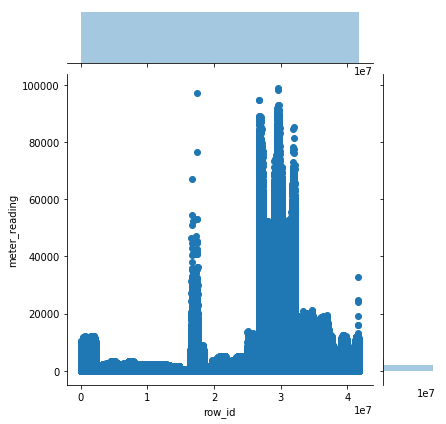

In [26]:
sns.jointplot("row_id","meter_reading",data=sample_submission)

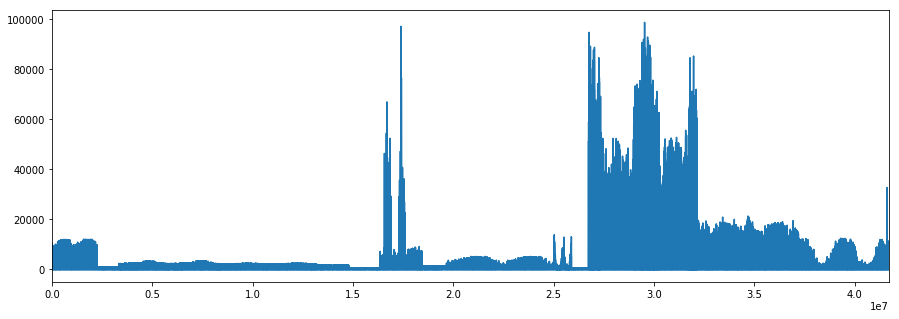

In [27]:
plt.figure(figsize = (15,5))
sample_submission['meter_reading'].plot()

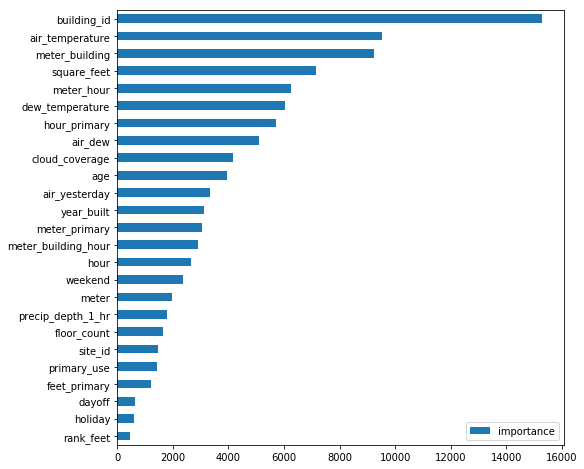

In [28]:
plot_feature_importance(models[0])

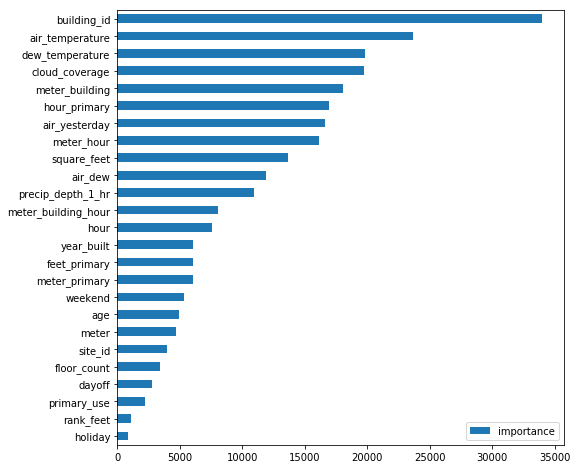

In [29]:
plot_feature_importance(models[1])

In [30]:
%%time
leak_sub = pd.read_csv("../input/ashrae-leak-data/submission_leak.csv")
for i in range(41697600):
    if(leak_sub.at[i,"meter_reading"]!=0):
        sample_submission.at[i,"meter_reading"]=leak_sub.at[i,"meter_reading"]
del leak_sub
gc.collect()

sample_submission.to_csv('submission_leak_replaced.csv', index=False)
sample_submission

CPU times: user 36min 56s, sys: 5.95 s, total: 37min 2s
Wall time: 37min 1s


,row_id,meter_reading
0,0,173.370300
1,1,53.512700
2,2,6.143000
3,3,101.701500
4,4,1141.240700
...,...,...
41697595,41697595,6.608020
41697596,41697596,4.828550
41697597,41697597,3.924622
41697598,41697598,174.075007


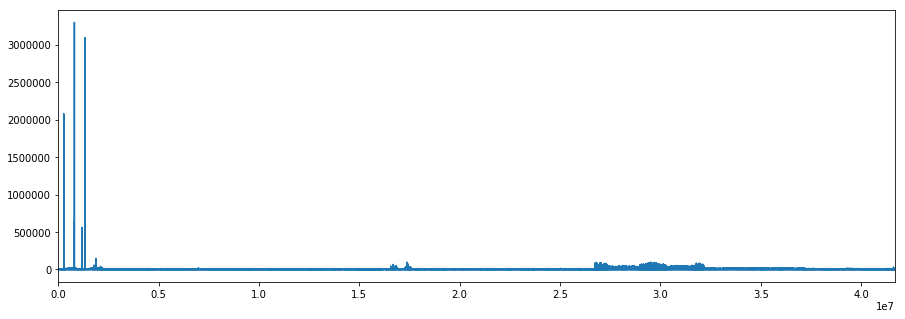

In [31]:
plt.figure(figsize = (15,5))
sample_submission['meter_reading'].plot()